# 1. 패키지 import + 데이터 다운로드


In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

#샘플수 확인
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [4]:
data.sample(10)

,headlines,text
39895,Afghanistan pacer breaks stump into two agains...,Afghanistan pacer Shapoor Zadran's delivery to...
39188,Orangutan tries to fight off bulldozer destroy...,A footage released by an animal welfare group ...
29077,4 students top CBSE Class 10 Board exams with ...,"Prakhar Mittal from Gurugram, Rimjhim Agrawal ..."
94606,Yoga Club inaugurated in Japanese Parliament,A 'Yoga Club' inspired by Indian spiritual lea...
56686,'Feminism' named Word of the Year by Merriam-W...,'Feminism' has been named the Word of the Year...
34979,Gave away Tipu Sultan's sword as it brought ba...,Vijay Mallya has told a London court that he g...
83307,Off-duty female cop subdues flier opening emer...,Off-duty female police officer Pamela Minchew ...
57117,We don't want to become a bank: MobiKwik Co-fo...,"When asked about expanding to a payments bank,..."
16629,PM Modi blind to plight of manual scavengers: ...,"Terming Swachh Bharat as a ""hollow slogan"", Co..."
54272,Pakistani lawmaker demands ban on Doraemon,A Pakistani lawmaker has submitted a resolutio...


- 추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 설정할 수 있음   
- 추출적 요약을 하는 경우에는 text열만을 사용

# 2. 데이터 전처리
- 중복 데이터 처리하기   
- null값 처리하기   
- 정규화 하기   
- 불용어 제거   
- 데이터 샘플 최대 길이 정하기   
- 시작, 종료 토큰 추가하기      
- 데이터셋 분리하기   
- 정수 인코딩   
- 패딩하기   

### 1) 중복 데이터 처리하기 

In [5]:
#중복 확인하기
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [6]:
#중복 제거하기
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 2) null값 처리하기

In [13]:
#null값 확인하기
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


null 값이 없다!!   
우선 제거를 패스한다

### 3) 정규화 하기

In [14]:
#텍스트 = 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


### 4) 불용어 제거 

In [19]:
#불용어 제거
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    sentence = re.sub('https?://\S+|www\.\S+', '', sentence)#url 제거
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [20]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [21]:
clean_headlines = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [135]:
print(data.isnull().sum())

headlines         0
text              0
decoder_input     0
decoder_target    0
dtype: int64


### 5) 데이터 샘플 최대 길이 정하기 

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
텍스트의 길이 분산 : 2.3842567599226006
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 18
헤드라인의 평균 길이 : 9.553660024400163


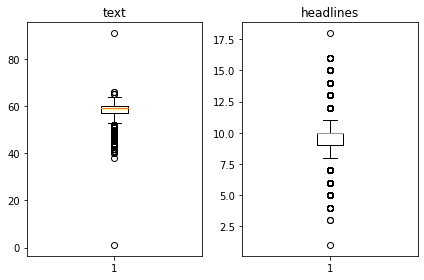

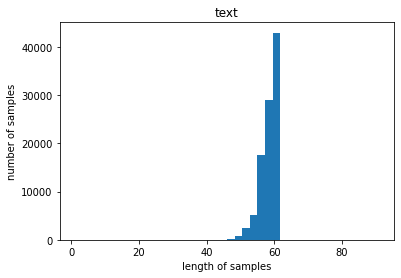

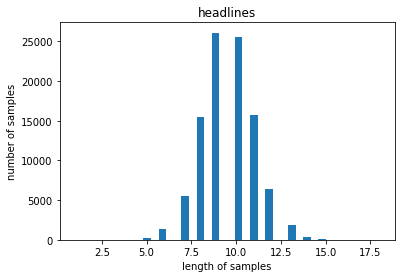

In [28]:
# 길이 분포 확인하기
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('텍스트의 길이 분산 : {}'.format(np.std(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

정제된 데이터를 확인해보니 다음과 같은 특징이 발견되었다.   
1. 텍스트와 헤드라인 모두 데이터의 최소 크기가 1이다   
2. 텍스트 데이터의 길이는 평균 약 58이며, 데이터 대부분이 약 50대 중후반~60대 초반에 몰려 있는 것을 볼 수 있다.   
3. 헤드라인 데이터의 길이는 평균 약 10이며, 전반적으로 고르게 분포한다.   

여기서 궁금한 점   
->과연 데이터 길이가 1인 데이터는 무엇일까..   
리소스 낭비하긴하지만 찾아보자   


In [61]:
data[data["text"].str.len()<100]

,headlines,text
52,headlines,text


In [66]:
data[data["text"].str.len()<250]

,headlines,text
4281,No more skipping breakfast with '3 Minute Brea...,Backed by the observation that breakfast is th...
22479,Vodafone RED Postpaid offers Amazon Prime at n...,Make the #SmartestMove & get 1-year of Amazon ...


data[data["text"].str.len()<100]로 입력하니까 각 칸 안에 있는 문자 하나하나의 길이로 따지는 것 같다.    
우선은 52번 컬럼을 지워야겠다.

In [62]:
data=data.drop(52)

텍스트의 최소 길이 : 38
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23871735174209
텍스트의 길이 분산 : 2.3772734629468455
헤드라인의 최소 길이 : 3
헤드라인의 최대 길이 : 18
헤드라인의 평균 길이 : 9.5537469880743
헤드라인의 길이 분산 : 1.457642915029255


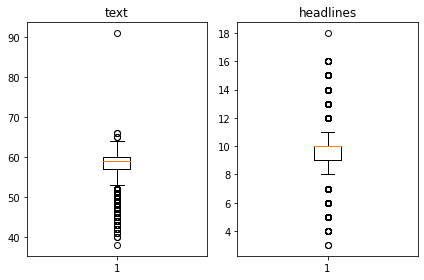

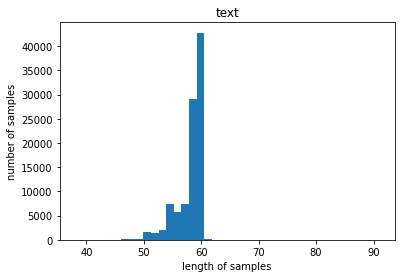

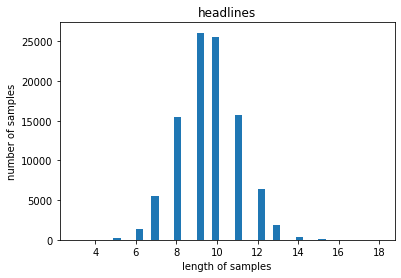

In [70]:
# 길이 분포 확인하기
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('텍스트의 길이 분산 : {}'.format(np.std(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('헤드라인의 길이 분산 : {}'.format(np.std(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

길이 1짜리 데이터가 모두 사라졌다.   
52번 컬럼이 길이 1짜리 데이터가 맞았다.

In [81]:
#샘플 최대 길이 설정
text_max_len = 60
headlines_max_len = 12

In [82]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [83]:
#샘플 포함 비율 확인하기
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.9974481237100824
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.976819609796765


In [84]:
#최대 길이보다 길면 제외
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 95837


### 6) 시작, 종료 토큰 추가하기

In [85]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,sostoken Delhi techie wins free food from Swig...,Delhi techie wins free food from Swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,sostoken Rahat Fateh Ali Khan denies getting n...,Rahat Fateh Ali Khan denies getting notice for...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...,sostoken Govt directs Alok Verma to join work ...,Govt directs Alok Verma to join work 1 day bef...


In [87]:
#인코더의 이볅, 디코더의 입력과 레이블 다시 numpy로 저장해주기
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 7) 데이터셋 분리하기

In [88]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19167


In [89]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 76670
훈련 레이블의 개수 : 76670
테스트 데이터의 개수 : 19167
테스트 레이블의 개수 : 19167


### 8) 단어집합 만들기 & 정수 인코딩

단어집합 = 각 단어에 고유한 정수 맵핑하는 작업

인코더 데이터에 대한 단어집합 제작 및 정수 인코딩 수행

In [90]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [98]:
threshold = 8 #등장횟수 8회 미만인 단어 제외
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 90173
등장 빈도가 7번 이하인 희귀 단어의 수: 67461
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22712
단어 집합에서 희귀 단어의 비율: 74.8128597251949
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.039723260612898


In [100]:
#단어 집합 크기 설정(등장횟수 임계치에 걸린 단어 제외한 나머지 단어의 크기에서 계산)
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [101]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[805, 11, 8120, 1582, 2414, 58, 4, 945, 4050, 104, 95, 59, 284, 244, 1476, 633, 337, 56, 2053, 4, 3, 776, 341, 104, 1, 8120, 204, 27, 10, 1, 1394, 10931, 1308, 344, 1, 1987, 12, 268, 945, 1352, 27, 738, 185, 21, 3960, 74, 1, 738, 11, 945, 1352, 27, 12, 3834, 15, 275, 344, 15, 8120, 14, 33], [3, 218, 217, 55, 306, 28, 12, 112, 6, 2130, 15, 14319, 49, 4, 3, 208, 3128, 7, 1, 265, 500, 2664, 1035, 8, 357, 31, 1015, 26, 10, 1, 1035, 29, 4232, 18, 1, 489, 879, 157, 21258, 177, 11, 1, 594, 1233, 500, 1361, 34, 2569, 6, 16583, 26, 189, 22, 269, 367, 50, 703, 185], [3, 41, 2317, 1030, 8, 1094, 8927, 6, 4772, 616, 22, 17365, 2498, 209, 137, 2077, 5, 188, 3695, 77, 2570, 286, 5329, 166, 1752, 1, 1030, 1007, 1, 903, 2726, 11, 1, 6704, 78, 2351, 1630, 6, 4286, 3462, 1, 339, 2342, 22, 1419, 5622, 5, 4772, 3975, 221, 20, 6082, 6, 7910, 20, 444, 20, 60, 4837, 2570, 12680]]


디코더 데이터에 대한 단어집합 제작 및 정수 인코딩 수행

In [102]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [104]:
threshold = 5 #등장회수 5회미만인 단어 제외
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40465
등장 빈도가 4번 이하인 희귀 단어의 수: 27916
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 12549
단어 집합에서 희귀 단어의 비율: 68.98801433337452
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.4794187596690085


In [105]:
tar_vocab = 12000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 234, 395, 6766, 988, 4, 2194, 523, 524, 191, 89], [1, 375, 52, 1322, 16, 7544, 65, 185], [1, 10, 603, 172, 129, 2578, 3, 392, 58, 1545, 5, 1967, 200], [1, 12, 120, 3393, 637, 4, 18, 57, 5, 101, 1612], [1, 735, 1085, 204, 4988, 49, 85, 5169, 4, 12, 4, 789, 319]]
target
decoder  [[234, 395, 6766, 988, 4, 2194, 523, 524, 191, 89, 2], [375, 52, 1322, 16, 7544, 65, 185, 2], [10, 603, 172, 129, 2578, 3, 392, 58, 1545, 5, 1967, 200, 2], [12, 120, 3393, 637, 4, 18, 57, 5, 101, 1612, 2], [735, 1085, 204, 4988, 49, 85, 5169, 4, 12, 4, 789, 319, 2]]


In [106]:
#빈 샘플 제거해주기
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 76670
훈련 레이블의 개수 : 76670
테스트 데이터의 개수 : 19167
테스트 레이블의 개수 : 19167


### 9)패딩하기

In [107]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# 3. 모델 설계하기

### 1) 인코더

In [112]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

#시간 관계상 먼저 보통 dropout으로 진행
# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)#, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)#, recurrent_dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)#, recurrent_dropout = 0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 2) 디코더

In [113]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

### 3) 디코더 출력층 설계

In [114]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 60, 128)      2816000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 60, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 4) 어텐션 메커니즘

In [115]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 60, 128)      2816000     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 60, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

# 4. 모델 훈련하기

In [116]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
300/300 [==============================] - 56s 162ms/step - loss: 5.9380 - val_loss: 5.4954
Epoch 2/50
300/300 [==============================] - 48s 161ms/step - loss: 5.3665 - val_loss: 5.0849
Epoch 3/50
300/300 [==============================] - 48s 160ms/step - loss: 4.9782 - val_loss: 4.7948
Epoch 4/50
300/300 [==============================] - 48s 161ms/step - loss: 4.7010 - val_loss: 4.6075
Epoch 5/50
300/300 [==============================] - 48s 160ms/step - loss: 4.4904 - val_loss: 4.4649
Epoch 6/50
300/300 [==============================] - 48s 161ms/step - loss: 4.3116 - val_loss: 4.3502
Epoch 7/50
300/300 [==============================] - 48s 161ms/step - loss: 4.1611 - val_loss: 4.2528
Epoch 8/50
300/300 [==============================] - 48s 160ms/step - loss: 4.0285 - val_loss: 4.1753
Epoch 9/50
300/300 [==============================] - 48s 160ms/step - loss: 3.9113 - val_loss: 4.1112
Epoch 10/50
300/300 [==============================] - 48s 160ms/step - l

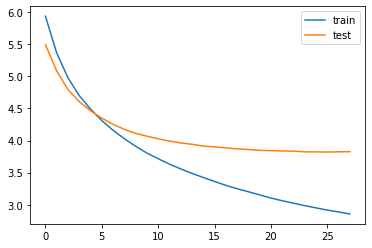

In [117]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

loss가 줄어들다 전체 50 에포크 중 28번째 이후로 줄지 않아 종료되었다.   
dropout = 0.4로 설정하였을 때 결과이다.

# 5. 인퍼런스 모델 구현하기    

텍스트 데이터 실제로 복원하기 위해 3개 사전을 미리 정의

In [124]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

인퍼런스 위한 모델 설계   
인코더와 디코더 모델을 분리해 설계

In [125]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘 사용하는 출력층 설계

In [126]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 만들기

In [131]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 6. 모델 테스트하기

In [132]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2head(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [133]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2head(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : sharing her picture with late actress sridevi taken on the sets of 'zero' karisma kapoor wrote thank you team 'zero' for giving me the opportunity to share screen space with the legend and my all time favourite sridevi sridevi who passed away earlier this year has a cameo in 'zero' along with karisma kajol rani mukerji and alia bhatt 
실제 요약 : all time favourite sridevi karisma on pic from sets of zero 
예측 요약 :  sridevi shares pic with sridevi from her 1st film on debut


원문 : windies batsman viv richards has said he loves virat kohli's captaincy india weren't like this in 1970s 1980s or 1990s but it's nice to have someone like virat i love it aggression why not they now love to give it back that's what cricket is all about he added indian team today is the team to beat he further said 
실제 요약 : love kohli's captaincy india now love to give it back richards 
예측 요약 :  kohli is not virat kohli on kohli's remark


원문 : bengaluru based home healthcare startup medical has raised 26 milli

예측 요약 :  i was a lot of my life arjun kapoor


원문 : a report submitted by a special investigation team sit has claimed that uttar pradesh police constable prashant chaudhary shot dead apple executive vivek tiwari without any provocation it added that chaudhary who earlier claimed he shot in self defence had opened fire without any immediate threat to his life the seven member sit was headed by inspector general pandey 
실제 요약 : police firing that killed apple exec was sit 
예측 요약 :  police officer booked for killing in up


원문 : the 18 rebel aiadmk mlas will not move the supreme court against the madras high court's order upholding their disqualification but will face the by elections leader ttv dhinakaran said chief election commissioner op rawat had said the commission will start making arrangements for by elections if the disqualified mlas fail to challenge the verdict within 30 days 
실제 요약 : 18 aiadmk rebel mlas won't challenge disqualification order 
예측 요약 :  sc moves sc to hear ple

예측 요약 :  i was a lot of a ball tampering scandal


원문 : google's self driving car spinoff company waymo has launched an educational campaign called talk self for fully self driving cars the campaign aims to increase understanding of self driving technology and how it can help address safety challenges on roads waymo has collaborated with several digital outdoor and radio advertising organisation in arizona us for the same 
실제 요약 : waymo launches educational campaign for self driving cars 
예측 요약 :  google unveils self driving cars in self driving cars


원문 : senior rss leader suresh joshi on thursday said india has never considered pakistan as its enemy while pakistan has always considered india as its enemy he further claimed india has never considered china our enemy but china behaves with india as if it is our enemy bangladesh has resorted to a passive attack on india through infiltration he added 
실제 요약 : india never considered pakistan china as its enemies rss 
예측 요약 :  india shoul

# Summa 이용한 추출 요약 해보기

In [134]:
import requests
from summa.summarizer import summarize

In [141]:
text = requests.get("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv").text

In [ ]:
print('Summary:')
print(summarize(text, ratio=0.005))